# TP 3: Q-learning

_Ismaël Bonneau_

Ce TP sert de compte-rendu pour le TP 3 et d'explication à la fois.

Algorithmes implémentés:

- Q-learning en version basique
- Q-learning en version SARSA

## Le Q-learning: associer une valeur à chaque couple (état, action)

On définit une fonction ${Q}$ qui prend une valeur d'état ${s_t}$ et une valeur d'action ${a_t}$ (${s_t}$ signifie: un certain état ${s}$ au temps ${t}$). Cette fonction ${Q(s_t, a_t)}$ renvoie une valeur indiquant l'estimation que l'on fait de la récompense que l'on attend si, en partant de ${s}$ à l'instant ${t}$, on effectue l'action ${a}$.

Cela peut permettre de dériver une politique greddy par exemple: Une fois la fonction ${Q}$ connue, on pourrait choisir, à chaque étape ${t}$ pour chaque état ${s_t}$ , d'effectuer l'action ${a}$ ayant la plus grande valeur ${Q(s_t, a)}$.  

<img src="images/qlearning_principle.png">

Il faut bien entendu pour cela estimer la fonction ${Q}$. On va pour ça initialiser une fonction ${Q}$ (généralement 0 partout au début) et l'estimer en jouant. A chaque étape ${t}$, notre agent agit selon sa fonction ${Q}$ actuelle, en considérant l'état ${s_t}$ dans lequel il se trouve, puis se retrouve dans un nouvel état ${s_{t+1}}$ en ayant reçu une récompense ${r}$. Il va ensuite mettre à jour sa fonction ${Q}$ en utilisant cette règle:

<img src="images/qlearning_updaterule.png">

In [7]:
import numpy as np
import gym
import gridworld
from gym import wrappers, logger

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Nous allons l'appliquer sur un jeu simple, GridWorld

Il s'agit d'un petit jeu en labyrinthe simple dans lequel un personnage (carré) doit rejoindre un endroit d'arrivée et évitant les flammes. Un reward positif est donné à l'arrivée, un négatif au passage dans les flammes et un reward négatif très petit (${-0.01}$ par exemple est donné aux autres cases, cela pour limiter le temps passé à cheminer à traver le labyrinthe.

Configurons l'environnement Gym pour gridworld-v0. Il a besoin de 2 choses:

- Un plan (le numéro 4 par exemple, qui est déjà assez complexe)
- Des valeurs associées à chaque type de case. 0 correspond à une case vide, 1 correspond à
un mur (pas de reward associé car impossible de s'y déplacer), 2 correspond au joueur,
3 correspond à une case verte, 4 une case jaune, 5 une case rouge et 6 une case rose

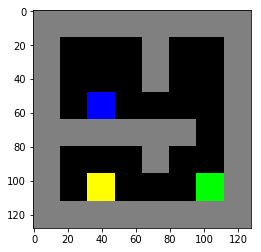

In [42]:
env = gym.make("gridworld-v0")
outdir = 'TP3/qlearning-agent-results'
envm = wrappers.Monitor(env, directory=outdir, force=True, video_callable=False)
env.setPlan("gridworldPlans/plan2.txt", {0: -0.001, 3: 1, 4: 1, 5: -1, 6: -1}) # initialiser le plan
env.seed(0)
lol = env.render() #visualiser le plan

### Nous allons définir deux classes d'agent

Un agent prenant des décisions complètement aléatoire, et un agent faisant du Q-learning. Cela servira comme point de comparaison.

In [8]:
class RandomAgent(object):
    """The world's simplest agent!"""
    def __init__(self, action_space):
        self.action_space = action_space

    def act(self, observation, reward, done):
        return self.action_space.sample()

In [52]:
import random
import operator

class Qagent(object):
    """ Q-learning agent """
    def __init__(self, env, gamma=0.99, alpha=0.8, epsilon=0.1):
        self.env = env
        self.Q = {} # initialement vide: on ne connait rien

        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.last_action = None

    def register_state(self, state):
        if state not in self.Q:
            self.Q[state] = {a: 0 for a in range(self.env.action_space.n)}
                
    def act(self, observation, reward, done):
        """ On parle pas chinois ici """
        state = self.env.state2str(observation)
        self.register_state(state)
        # epsilon-greedy:
        if random.random() < self.epsilon:
            # sampler une action au hasard
            chosen_action = self.env.action_space.sample()
        else:
            # sinon, effectuer l'action conforme à la politique
            chosen_action = np.argmax(self.Q[state])

        self.last_action = chosen_action
        self.last_state = state
        return chosen_action

    def improve(self, observation, reward, done):
        """ Hassoul y'a qu'le charbon qui paie """
        new_state = self.env.state2str(observation)
        self.register_state(new_state)
        LPBDTLR = self.gamma * max(self.Q[new_state].items(), key=operator.itemgetter(1))[1]
        self.Q[self.last_state][self.last_action] = ((1 - self.alpha) * self.Q[self.last_state][self.last_action]) + self.alpha * (reward + LPBDTLR)

In [ ]:
GAMMA = 0.99
LEARNING_RATE = 0.01
EPSILON = 0.1

agent = Qagent(env, gamma=GAMMA, alpha=LEARNING_RATE, epsilon=EPSILON)

nbruns = 300

for i in range(nbruns):
    obs = envm.reset()
    rsum = 0
    reward = 0
    done = False
    j = 0
    while True:
        action = agent.act(obs, reward, done)
        obs, reward, done, _ = envm.step(action)
        agent.improve(obs, reward, done)
        rsum = (rsum * GAMMA) + reward
        j += 1
        if done:
            if i % 10 == 0:
                print("episode", i," rsum=" + str(rsum) + ", au bout de " + str(j) + " actions")
            break
env.close()